## Unfair TOS

#### The previous jupyter_notebook contains visualizations for the data. Most of the problematic clauses have many interesting trigrams that we can use in our machine learning or deep learning models. 


### Baseline experiment
1. Simplest model(chery picked example and full dataset)
2. Overfit on one cherry picked example
3. Write model and training loop
4. Run for a larger number of epochs
5. Compute metrics
6. Try a meta-learning example

In [7]:
#------# Import libraries and datasets #------#

import numpy as np
import torch
import datasets as dts
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
%matplotlib inline

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import ClassifierChain
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score

In [2]:
dataset = dts.load_dataset('lex_glue','unfair_tos')

Found cached dataset lex_glue (/home/anas/.cache/huggingface/datasets/lex_glue/unfair_tos/1.0.0/8a66420941bf6e77a7ddd4da4d3bfb7ba88ef48c1d55302a568ac650a095ca3a)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
train_dataset = pd.DataFrame.from_dict(dataset["train"])
val_dataset = pd.DataFrame.from_dict(dataset["validation"])
test_dataset = pd.DataFrame.from_dict(dataset["test"])

stop_words = list(stopwords.words('english'))

### Using a simple logistic regression
In the below example we use a simple logistic regression model with 
1. Binary relevance where we have four separate classifiers but their is no label correlation. The performance is obviously very bad.
2. Classifier chain. The performance for this is even worse
3. Binary relevance with simple undersampling
4. Binary relevance with tomek undersampling

In [4]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
                ('clf', BinaryRelevance(LogisticRegression(solver='sag'))),
            ])

mlb = MultiLabelBinarizer()
mlb.fit(train_dataset['labels'])
y_transformed = mlb.transform(train_dataset['labels'])

pipeline.fit(train_dataset['text'], y_transformed)


predictions = pipeline.predict(test_dataset["text"])


print('Accuracy = ', accuracy_score(mlb.transform(test_dataset["labels"]),predictions))
print('micro-F1 score is ',f1_score(mlb.transform(test_dataset["labels"]), predictions, average="micro"))
print('macro-F1 score is ',f1_score(mlb.transform(test_dataset["labels"]), predictions, average="macro"))
print('Hamming Loss is ', hamming_loss(mlb.transform(test_dataset["labels"]), predictions))

Accuracy =  0.910392034847542
micro-F1 score is  0.2972972972972973
macro-F1 score is  0.2394898528151031
Hamming Loss is  0.012134411947728687


In [5]:
pipeline2 = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', ClassifierChain(LogisticRegression(solver='sag'))),
            ])

pipeline2.fit(train_dataset['text'], y_transformed)


predictions = pipeline2.predict(test_dataset["text"])


print('Accuracy = ', accuracy_score(mlb.transform(test_dataset["labels"]),predictions))
print('micro-F1 score is ',f1_score(mlb.transform(test_dataset["labels"]), predictions, average="micro"))
print('macro-F1 score is ',f1_score(mlb.transform(test_dataset["labels"]), predictions, average="macro"))
print('Hamming Loss is ', hamming_loss(mlb.transform(test_dataset["labels"]), predictions))

# THe accuray of the classifier chain is even less. 

Accuracy =  0.9079029247044181
micro-F1 score is  0.2780269058295964
macro-F1 score is  0.1967032967032967
Hamming Loss is  0.012523335407591787


In [32]:
# starting with simple

def list_it(curr):
    return [curr]

train_dataset['text_2d'] = train_dataset["text"].apply(list_it)

rus = RandomUnderSampler(sampling_strategy='majority')
X_train_resampled, y_train_resampled = rus.fit_resample(np.array(train_dataset["text_2d"]).reshape(-1, 1),train_dataset['str_labels'])

In [54]:
def str2list(curr):
    if curr=="[]":
        return []
    else:
        return [int(x) for x in curr[1:-1].split(',')]

def delist_it(curr):
    new_list = []
    for i in curr:
        new_list.append(i[0][0])
    return new_list
random_undersample = pd.DataFrame({'text':delist_it(X_train_resampled)})
new_list = y_train_resampled.apply(str2list)
random_undersample['labels'] = new_list

<AxesSubplot:ylabel='labels'>

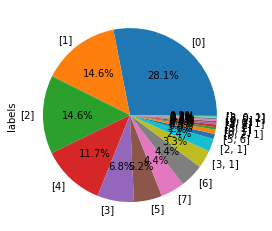

In [57]:
# distribution of samples based after random undersampling
random_undersample['labels'].value_counts().plot.pie(autopct='%1.1f%%')

In [59]:
# training our best logistic regression model with the resampled data
pipeline3 = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
                ('clf', BinaryRelevance(LogisticRegression(solver='sag'))),
            ])

mlb = MultiLabelBinarizer()
mlb.fit(random_undersample['labels'])
y_transformed = mlb.transform(random_undersample['labels'])

pipeline3.fit(random_undersample['text'], y_transformed)


predictions = pipeline3.predict(test_dataset["text"])


print('Accuracy = ', accuracy_score(mlb.transform(test_dataset["labels"]),predictions))
print('micro-F1 score is ',f1_score(mlb.transform(test_dataset["labels"]), predictions, average="micro"))
print('macro-F1 score is ',f1_score(mlb.transform(test_dataset["labels"]), predictions, average="macro"))
print('Hamming Loss is ', hamming_loss(mlb.transform(test_dataset["labels"]), predictions))
# OMG the performance actually increased! This shows that resampling strategy works best 

Accuracy =  0.8861232109520847
micro-F1 score is  0.5148514851485148
macro-F1 score is  0.5293635745421343
Hamming Loss is  0.015245799626633479
